In [0]:
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.transforms as transforms

import matplotlib.pyplot as plt
import numpy as np

In [0]:
transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,),(0.5,))
])

batch_size = 4

trainset = torchvision.datasets.MNIST(root='./data', train=True,
                                     download=True, transform = transforms)
trainloader = torch.utils.data.DataLoader(trainset,
                                          batch_size=batch_size,
                                          shuffle = True,
                                          num_workers=2
                                         )

testset = torchvision.datasets.MNIST(root='./data', train=False,
                                    download = True, transform=transforms)
testloader = torch.utils.data.DataLoader(testset, 
                                         batch_size=batch_size,
                                         shuffle=False, 
                                         num_workers=2
                                        )

In [0]:
class Model(nn.Module):
  def __init__(self):
    super(Model, self).__init__()
    
    self.conv1 = nn.Conv2d(1, 6, 3)
    self.pool = nn.MaxPool2d(2, 2)
    self.conv2 = nn.Conv2d(6, 20, 3)
    
    self.fc1 = nn.Linear(20 * 5 * 5, 120)
    self.fc2 = nn.Linear(120, 84)
    self.fc3 = nn.Linear(84, 10)
    
  def forward(self, x):
    x = self.pool(F.relu(self.conv1(x)))
    x = self.pool(F.relu(self.conv2(x)))
    
    x = x.view(-1, 20 * 5 * 5)
    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
    x = self.fc3(x)
    return x
  
model = Model()  

In [11]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

model.to(device)

Model(
  (conv1): Conv2d(1, 6, kernel_size=(3, 3), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 20, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=500, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

# Cyclical Learning Rate Schedule

The learning rate schedule is,

$$\eta_{t} = \eta_{min} + (\eta_{max} - \eta_{min}) * max(0, 1 - x )$$

where $x$ is defined as, 

$$ x = \left | \frac{iterations}{stepsize} - 2 * cycle + 1  \right | $$ 

and $cycle$ can be calculated as,

$$ cycle = floor(\frac{1+iterations}{2 * stepsize}) $$

## Terminology:

$\eta_{min}, \eta_{max}$ = Learning rate boundary

$iterations$ = no of completed mini-batches

$stepsize$ = $\frac{1}{2}$ of a cycle length

In [0]:
class MyCyclicLR(object):
  def __init__(self, optimizer, base_lr = 1e-3, max_lr = 6e-3, 
               step_size = 2000, mode='triangular', 
               last_epoch=-1):
    
    self.optimizer = optimizer
    
    self.base_lrs = [base_lr] * len(optimizer.param_groups)
    
    self.max_lrs = [max_lr] * len(optimizer.param_groups)
    
    self.step_size = step_size
    
    self.step(last_epoch + 1)
    self.last_epoch = last_epoch
    
#     only implemented triangular.
    self.mode = mode
  
#   the step function will be called throughout the epochs
  def step(self, batch_iteration = None):
    if batch_iteration is None:
      batch_iteration = self.last_epoch + 1
      
    self.last_epoch = batch_iteration
    
#     now get the learning rate from get_lr() func and set to optimizer parameter's learning rate 
    for lr, param_group in zip(self.get_lr(), self.optimizer.param_groups):
        param_group['lr'] = lr
    
  def get_lr(self):
    step_size = float(self.step_size)
    cycle = np.floor(1 + self.last_epoch / (2 * step_size))
    x = np.abs(self.last_epoch / step_size - 2 * cycle + 1)
    
    lrs = []
    
    for base_lr, max_lr in zip(self.base_lrs, self.max_lrs):
      lr = base_lr + (max_lr - base_lr) * np.maximum(0, (1-x))
      
      lrs.append(lr)
    
    return lrs    

In [0]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001)
scheduler = MyCyclicLR(optimizer, base_lr=1e-3, max_lr=6e-3)

epoch: 1, iterations:  2000, loss: 2.256
epoch: 1, iterations:  4000, loss: 0.692
epoch: 1, iterations:  6000, loss: 0.359
epoch: 1, iterations:  8000, loss: 0.232
epoch: 1, iterations: 10000, loss: 0.181
epoch: 1, iterations: 12000, loss: 0.151
epoch: 1, iterations: 14000, loss: 0.135
epoch: 2, iterations:  2000, loss: 0.103
epoch: 2, iterations:  4000, loss: 0.120
epoch: 2, iterations:  6000, loss: 0.086
epoch: 2, iterations:  8000, loss: 0.099
epoch: 2, iterations: 10000, loss: 0.090
epoch: 2, iterations: 12000, loss: 0.097
epoch: 2, iterations: 14000, loss: 0.074


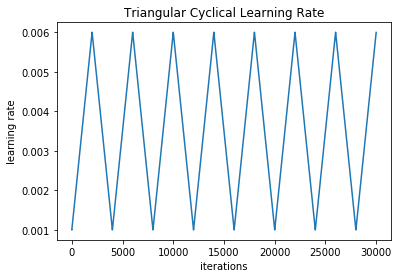

Finished Training


In [14]:
EPOCHS = 2
print_every = 2000

learning_rate = []

for epoch in range(EPOCHS):
  
  running_loss = 0.0
  
  for iters, data in enumerate(trainloader, 0):
    inputs, labels = data[0].to(device), data[1].to(device) 
    
#     make gradients parameter zero
    optimizer.zero_grad()
    
    learning_rate.append(scheduler.get_lr())
    
#     forward propagation
    outputs = model(inputs)
#   calculate loss
    loss = criterion(outputs, labels)
#   do backward propagation
    loss.backward()
#   update scheduler
    scheduler.step()
#   update weights
    optimizer.step()
   
#     print result
    running_loss += loss.item()
    if iters % print_every == 1999:
      print("epoch: %d, iterations: %5d, loss: %.3f" % 
           (epoch + 1, iters + 1, running_loss / print_every))
      
      running_loss = 0.0


plt.plot(learning_rate)
plt.xlabel('iterations')
plt.ylabel('learning rate')
plt.title("Triangular Cyclical Learning Rate")
plt.show()
print("Finished Training")

As you can see from the graph, the learning rate scheduler has formed triangular structure throughout the iterations. 

In [15]:
correct1 = 0
total = 0

with torch.no_grad():
  for data in testloader:
    images, labels = data[0].to(device), data[1].to(device)
    output1 = model(images)
    
    _, predicted = torch.max(output1.data, 1)
    
    total += labels.size(0)
    
    correct1 += (predicted == labels).sum().item()
    
print("Accuracy of the network using custom CLR: %2.3f %%" % (100 * correct1 / total))

Accuracy of the network using custom CLR: 97.460 %
